In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
import shutil
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [101]:
from google.colab import drive 
drive.mount('/content/gdrive')

PATH = '/content/gdrive/MyDrive/Colab Notebooks/'
PATH_IMG = '/content/gdrive/MyDrive/Colab Notebooks/connected_images/'

Mounted at /content/gdrive


# Предобработка данных

In [4]:
test = pd.read_csv(PATH + 'test.csv')
test_encoded = pd.read_csv(PATH + 'test_encoded.csv')
train = pd.read_csv(PATH + 'train.csv')
train_encoded = pd.read_csv(PATH + 'train_encoded.csv')

data = {'test': test, 'test_encoded': test_encoded, 'train': train, 'train_encoded': train_encoded}

In [ ]:
train.head()

,Unnamed: 0,image_name,type,xmin,xmax,ymin,ymax
0,0,0007Date_01_08_2019.jpg,other,285,368,61,278
1,1,0013Date_01_08_2019.jpg,armature,187,550,101,253
2,2,0016Date_01_08_2019.jpg,armature,172,327,13,360
3,3,0019Date_01_08_2019.jpg,armature,19,267,162,237
4,4,0019Date_01_08_2019.jpg,armature,309,548,300,376


In [ ]:
train_encoded.head()

,Image_name_Type,EncodedPixels
0,0007Date_01_08_2019.jpg_armature,1 1
1,0007Date_01_08_2019.jpg_other,43229 83 43933 83 44637 83 45341 83 46045 83 4...
2,0007Date_01_08_2019.jpg_wood,1 1
3,0013Date_01_08_2019.jpg_armature,71291 363 71995 363 72699 363 73403 363 74107 ...
4,0013Date_01_08_2019.jpg_other,1 1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2541 non-null   int64 
 1   image_name  2541 non-null   object
 2   type        2541 non-null   object
 3   xmin        2541 non-null   int64 
 4   xmax        2541 non-null   int64 
 5   ymin        2541 non-null   int64 
 6   ymax        2541 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 139.1+ KB


In [ ]:
print("В тестовом наборе {} объектов \nВ обучающем наборе {} объектов".format(len(test), len(train)))

В тестовом наборе 1688 объектов 
В обучающем наборе 2541 объектов


## Размер изображений

In [6]:
# посмотрим на размер исходных изображений (вдруг что-то нужно будет нормаировать)
# добавим в таблицу новый признак - размер изображения

pic_size = set()

test_img_size = []
train_img_size = []

for key in ['train', 'test']:
  for i, row in data[key].iterrows():
    im = cv2.imread(PATH_IMG + row['image_name'])
    height, width, _ = im.shape
    pic_size.add((height, width))
    if key == 'train':
      train_img_size.append((height, width))
    else:
      test_img_size.append((height, width))

train['Size'] = train_img_size
test['Size'] = test_img_size

print(pic_size)
test.head()

{(576, 704), (421, 704)}


,Unnamed: 0,image_name,type,xmin,xmax,ymin,ymax,Usage,Size
0,0,0000Date_01_08_2019.jpg,armature,173,403,84,380,Public,"(421, 704)"
1,1,0029Date_01_08_2019.jpg,armature,54,307,29,346,Public,"(421, 704)"
2,2,0049Date_01_08_2019.jpg,armature,510,576,71,202,Public,"(421, 704)"
3,3,0054Date_01_08_2019.jpg,armature,124,213,1,102,Public,"(421, 704)"
4,4,0057Date_01_08_2019.jpg,armature,158,579,80,278,Public,"(421, 704)"


In [7]:
#посмотрим сколько каких размеров

size_table_train = train.groupby(['Size'])['Size'].count().reset_index(name='Count')
size_table_train

,Size,Count
0,"(421, 704)",2541


In [8]:
size_table_test = test.groupby(['Size'])['Size'].count().reset_index(name='Count')
size_table_test

,Size,Count
0,"(421, 704)",1686
1,"(576, 704)",2


Получается в тестовом наборе данных присутствуют два изображения с нетипичным размером.

Удалим эти объекты

In [9]:
len_before = len(test)
test = test.loc[test['Size'] != (576, 704)]
len_after = len(test)
print("удалено {} объекта".format(len_before-len_after))

удалено 2 объекта


## Проверка пропусков

In [ ]:
def check_empty(table):
  headers = table.columns
  count_null = pd.DataFrame(table[headers].isnull().sum())
  count_null = count_null.reset_index()
  count_null.rename(columns = {'index' : 'Column', 0 : 'Count_null'}, inplace = True) 
  
  return count_null

In [ ]:
for key in data:
  print(key + ':')
  print(check_empty(data[key]), '\n\n')

test:
       Column  Count_null
0  Unnamed: 0           0
1  image_name           0
2        type           0
3        xmin           0
4        xmax           0
5        ymin           0
6        ymax           0
7       Usage           0 


test_encoded:
            Column  Count_null
0  Image_name_Type           0
1    EncodedPixels           0
2            Usage           0 


train:
       Column  Count_null
0  Unnamed: 0           0
1  image_name           0
2        type           0
3        xmin           0
4        xmax           0
5        ymin           0
6        ymax           0 


train_encoded:
            Column  Count_null
0  Image_name_Type           0
1    EncodedPixels           0 




Пропусков нет

## Работа с признаками

In [ ]:
# посмотрим на варианты целевого признака
target = train['type'].unique()
print(target)

['other' 'armature' 'wood']


Варианты целевого признака:
- **other**
- **armature**
- **wood**

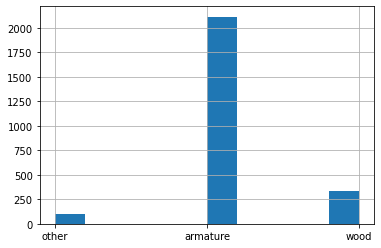

In [ ]:
# посмотрим на количество целевых признаков в обучающей выборке

h = train['type'].hist()
fig = h.get_figure()

Выборка не сбалансирована

In [ ]:
# у меня вызывают подозрения данные с EncodedPixels = 1 1 => 
# посмотрим на значения этого признака

temp = train_encoded.groupby(['EncodedPixels'])['EncodedPixels'].count().reset_index(name='Count')
temp[temp['Count'] > 1]

,EncodedPixels,Count
1,1 1,4540


Получается, в тренировочной выборке 4540 объекта имеют странное значение признака *EncodedPixels* = "1 1"

## Выделение объектов

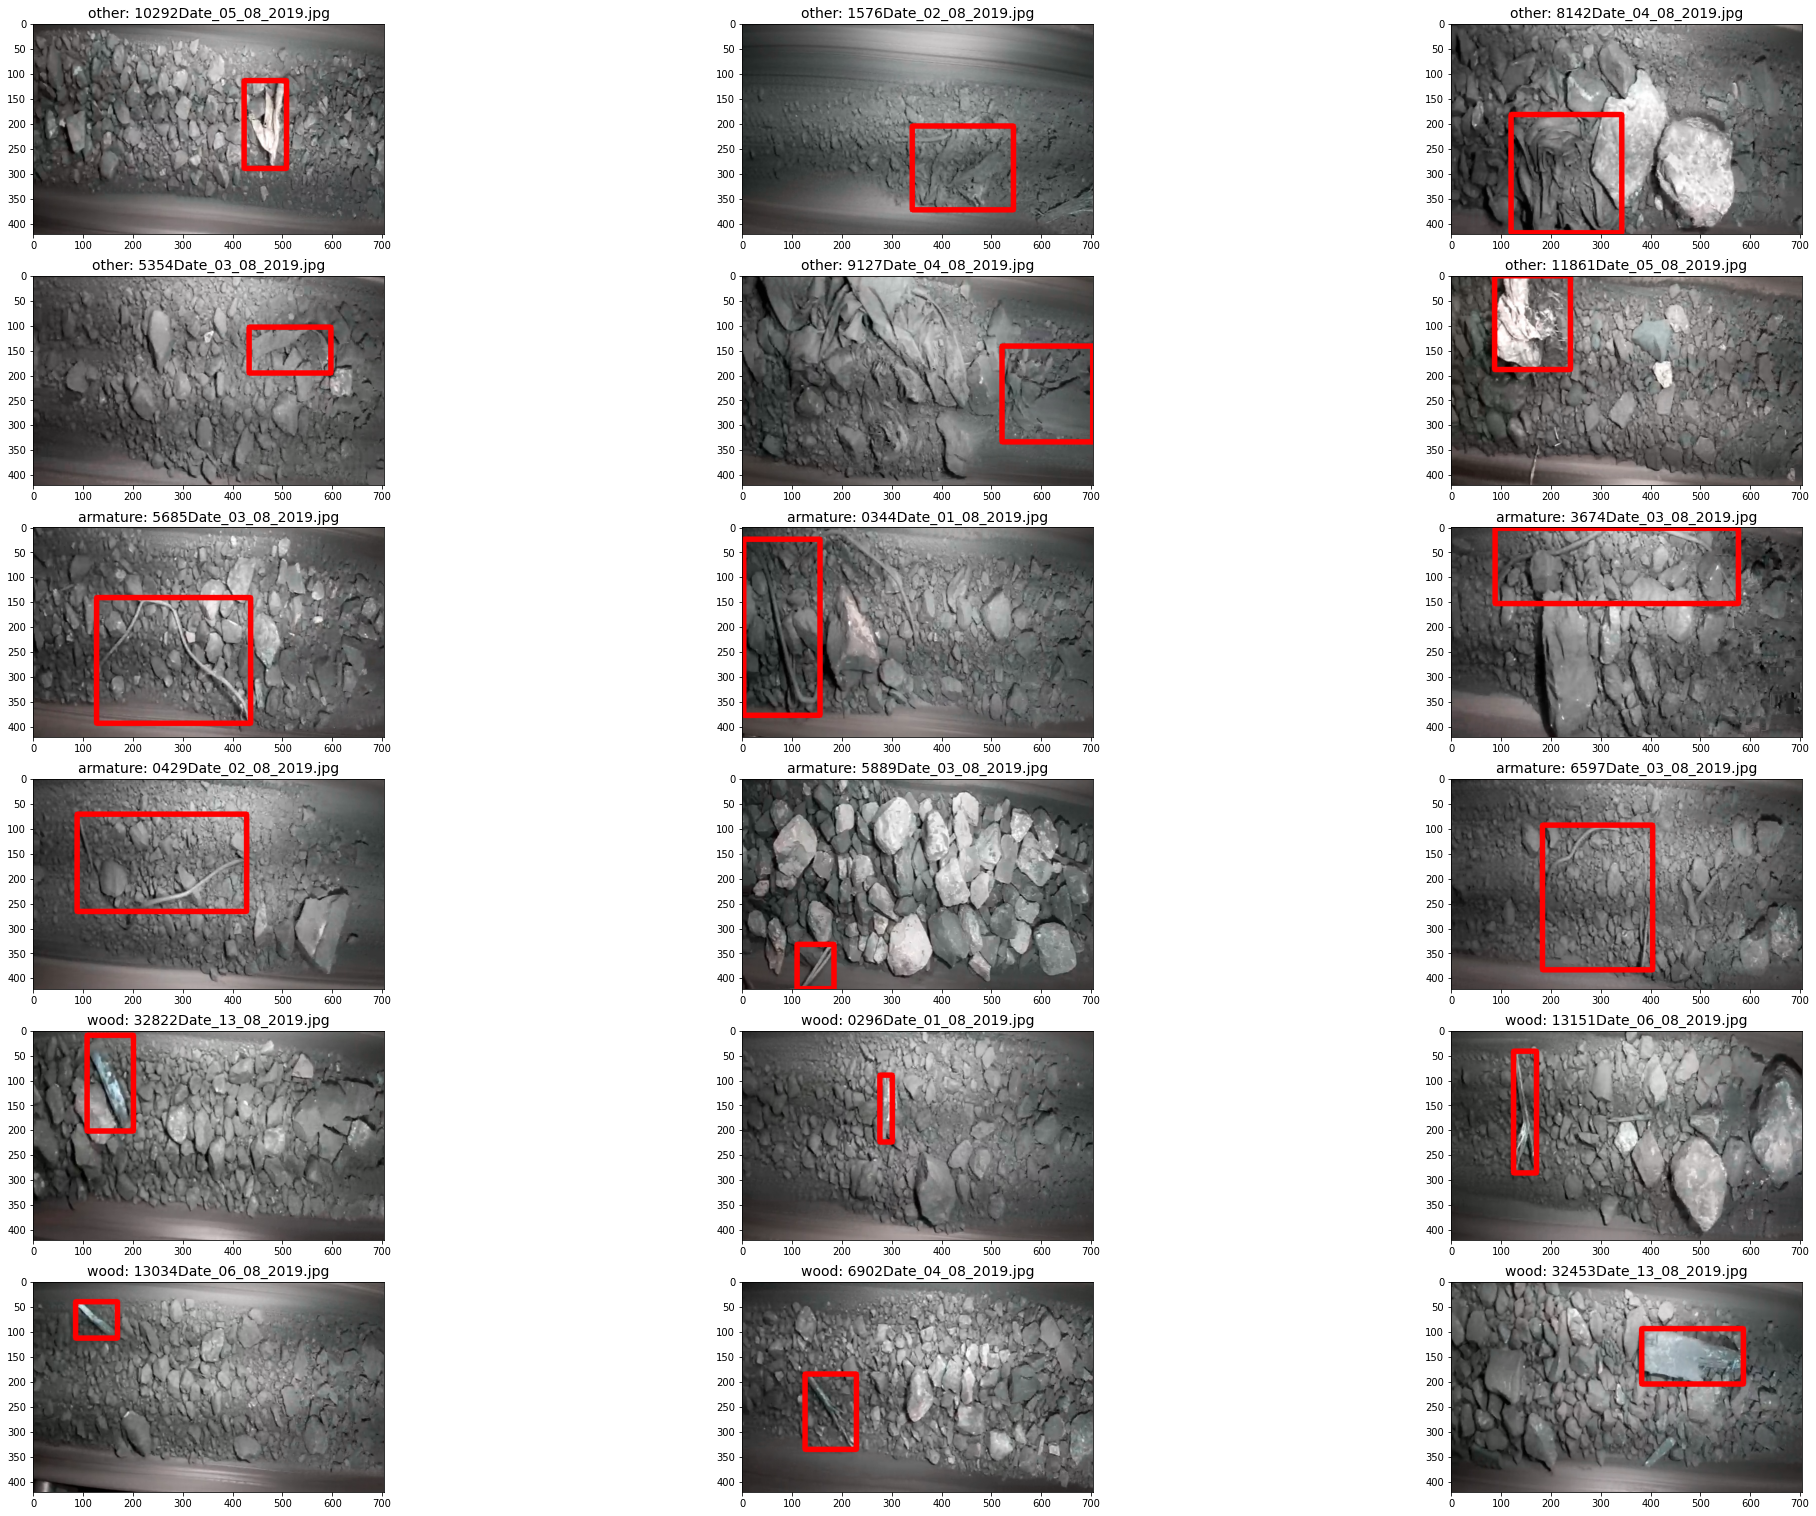

In [ ]:
# посмотрим, как выделялись объекты на изображениях
# cv2.rectangle(image, start_point, end_point, color, thickness)

other = train[train['type'] == 'other'].sample(n=6)
armature = train[train['type'] == 'armature'].sample(n=6)
wood = train[train['type'] == 'wood'].sample(n=6)

samples = {'other': other, 'armature': armature, 'wood': wood}

fig = plt.figure(figsize=(36, 27))
t = 1
for key in samples:
  for i, row in samples[key].iterrows():
    ax = fig.add_subplot(6, 3, t)
    ax.set_title(key + ': ' + row['image_name'], fontsize=14)
    im = cv2.imread(PATH_IMG + row['image_name'])
    x_min, x_max, y_min, y_max = row['xmin'], row['xmax'], row['ymin'], row['ymax']
    rec = cv2.rectangle(im, (x_min, y_min), (x_max, y_max), (255, 0, 0), 10)
    ax.imshow(rec, cmap='bone')
    t+=1

## Выделение изображений


In [62]:
# соберем датасет для классификации

armature_all = []
wood_all = []
other_all = []

for i, row in train.iterrows():
  im = cv2.imread(PATH_IMG + row['image_name'])
  x_min, x_max, y_min, y_max = row['xmin'], row['xmax'], row['ymin'], row['ymax']
  crop = im[y_min:y_max, x_min:x_max]
  if row['type'] == 'armature':
    armature_all.append(crop)
  elif row['type'] == 'wood':
    wood_all.append(crop)
  else:
    other_all.append(crop)

armature_all = pd.DataFrame(armature_all, columns=['img'])
wood_all = pd.DataFrame(wood_all, columns=['img'])
other_all = pd.DataFrame(other_all, columns=['img'])

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [20]:
# Разделение выборки на train, test, split
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [12]:
# Каталог с набором данных
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/test'
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для тестирования
test_dir = 'test'
# Каталог с валидационными данными
val_dir = 'val'
# Часть набора данных для тестирования
# test_data_portion = 0.15

In [ ]:
# создадим подкаталоги

# def create_directory(dir_name):
#     if os.path.exists(dir_name):
#         shutil.rmtree(dir_name)
#     os.makedirs(dir_name)
#     os.makedirs(os.path.join(dir_name, "armature"))
#     os.makedirs(os.path.join(dir_name, "wood"))   
#     os.makedirs(os.path.join(dir_name, "other"))   

In [25]:
# Создание структуры каталогов для обучающего и тестового набора данных

# create_directory(train_dir)
# create_directory(test_dir)

In [63]:
# Скопируем изображения в подкаталоги
# 70% - обучающая выборка
# 15% - валидационная выборка
# 15% - тестовая выборка

armature_train, armature_val, armature_test = train_validate_test_split(df=armature_all, train_percent=0.7, validate_percent=0.15)
wood_train, wood_val, wood_test = train_validate_test_split(df=wood_all, train_percent=0.7, validate_percent=0.15)
other_train, other_val, other_test = train_validate_test_split(df=other_all, train_percent=0.7, validate_percent=0.15)

In [64]:
# Проверим размеры полученных выборок
d = {'armature_train': armature_train, 'armature_val': armature_val, 'armature_test': armature_test,
          'wood_train': wood_train, 'wood_val': wood_val, 'wood_test': wood_test,
          'other_train': other_train, 'other_val': other_val, 'other_test': other_test}
i = 1
for key in d:
  print(f"{key}: {len(d[key])} ({len(d[key]) * 100.0 / len(eval( key[0 : key.find('_')] + '_all')) }%)", end='; ')
  if i % 3 == 0:
    print('\n')
  i += 1
  

armature_train: 1479 (69.99526739233318%); armature_val: 316 (14.955040227165169%); armature_test: 318 (15.049692380501657%); 

wood_train: 230 (69.6969696969697%); wood_val: 49 (14.848484848484848%); wood_test: 51 (15.454545454545455%); 

other_train: 68 (69.38775510204081%); other_val: 14 (14.285714285714286%); other_test: 16 (16.3265306122449%); 



In [91]:
# Сохранить изображения в подкаталоги

def save_images(data, dir, file_name):
  i = 0
  for i in range(len(data)):
    cv2.imwrite(dir + '/' + file_name + str(i) + '.jpg', data[i])

In [105]:
len(armature_train['img'].to_list())

1479

In [106]:
save_images(armature_train['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/train/armature', 'armature')
save_images(wood_train['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/train/wood', 'wood')
save_images(other_train['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/train/other', 'other')

save_images(armature_val['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/val/armature', 'armature')
save_images(wood_val['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/val/wood', 'wood')
save_images(other_val['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/val/other', 'other')

save_images(armature_test['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/test/armature', 'armature')
save_images(wood_test['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/test/wood', 'wood')
save_images(other_test['img'].to_list(), '/content/gdrive/MyDrive/Colab Notebooks/test/other', 'other')

# Модель

Для решения задачи нужно решить задачи сегментации и классификации.

In [112]:
# Размеры изображения
img_width, img_height = 150, 150

# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 5
# Размер мини-выборки
batch_size = 10

# Количество изображений для обучения
nb_train_samples_a = len(armature_train)
nb_train_samples_w = len(wood_train)
nb_train_samples_o = len(other_train)
# количетсво валидационных изображений
nb_val_samples_a = len(armature_val)
nb_val_samples_w = len(wood_val)
nb_val_samples_o = len(other_val)
# Количество изображений для тестирования
nb_test_samples_a = len(armature_test)
nb_test_samples_w = len(wood_test)
nb_test_samples_o = len(other_test)

In [98]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

In [99]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [107]:
# отнормируем значение пикселей
datagen = ImageDataGenerator(rescale=1. / 255)

# Генератор данных для обучения на основе изображений из каталога
train_generator = datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1777 images belonging to 3 classes.


In [110]:
# Генератор данных для валидации на основе изображений из каталога

val_generator = datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 379 images belonging to 3 classes.


In [109]:
# Генератор данных для тестирования на основе изображений из каталога

test_generator = datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 385 images belonging to 3 classes.


## Обучение

In [113]:
# train_generator - генератор данных для обучения
# validation_data - генератор данных для проверки

model.fit_generator(
    train_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


178/178 [==============================] - 61s 341ms/step - loss: 0.5348 - accuracy: 0.8323 - val_loss: 0.4472 - val_accuracy: 0.8338
Epoch 2/5
178/178 [==============================] - 61s 344ms/step - loss: 0.4507 - accuracy: 0.8317 - val_loss: 0.4023 - val_accuracy: 0.8443
Epoch 3/5
178/178 [==============================] - 60s 334ms/step - loss: 0.3875 - accuracy: 0.8469 - val_loss: 0.3898 - val_accuracy: 0.8654
Epoch 4/5
178/178 [==============================] - 58s 326ms/step - loss: 0.3582 - accuracy: 0.8559 - val_loss: 0.4774 - val_accuracy: 0.8549
Epoch 5/5
178/178 [==============================] - 59s 330ms/step - loss: 0.3175 - accuracy: 0.8745 - val_loss: 0.4553 - val_accuracy: 0.8654


## Оценка качества модели на тестовом наборе

In [116]:
scores = model.evaluate_generator(test_generator)
print(f"Accuracy_test = {round(scores[1] * 100, 2)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy_test = 83.12
